# Introducción

With the growth of data-centric Machine Learning, Active Learning has grown in popularity amongst businesses and researchers. Active Learning seeks to progressively train ML models so that the resultant model requires lesser amount of training data to achieve competitive scores.

The structure of an Active Learning pipeline involves a classifier and an oracle. The oracle is an annotator that cleans, selects, labels the data, and feeds it to the model when required. The oracle is a trained individual or a group of individuals that ensure consistency in labeling of new data.

The process starts with annotating a small subset of the full dataset and training an initial model. The best model checkpoint is saved and then tested on a balanced test set. The test set must be carefully sampled because the full training process will be dependent on it. Once we have the initial evaluation scores, the oracle is tasked with labeling more samples; the number of data points to be sampled is usually determined by the business requirements. After that, the newly sampled data is added to the training set, and the training procedure repeats. This cycle continues until either an acceptable score is reached or some other business metric is met.

This tutorial provides a basic demonstration of how Active Learning works by demonstrating a ratio-based (least confidence) sampling strategy that results in lower overall false positive and negative rates when compared to a model trained on the entire dataset. This sampling falls under the domain of uncertanity sampling, in which new datasets are sampled based on the uncertanity that the model outputs for the corresponding label. In our example, we compare our model's false positive and false negative rates and annotate the new data based on their ratio.

Some other sampling techniques include:

Committee sampling: Using multiple models to vote for the best data points to be sampled
Entropy reduction: Sampling according to an entropy threshold, selecting more of the samples that produce the highest entropy score.
Minimum margin based sampling: Selects data points closest to the decision boundary

In [ ]:
# importamos las librerías
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import string

tfds.disable_progress_bar()

In [ ]:
# Carga y preprocesado de los datos
dataset = tfds.load(
    "imdb_reviews",
    split="train + test",
    as_supervised=True,
    batch_size=-1,
    shuffle_files=False,
)
reviews, labels = tfds.as_numpy(dataset)
print("Total reviews :", reviews.shape[0])

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXBM2GT/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXBM2GT/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXBM2GT/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Total reviews : 50000


In [ ]:
# Active Learning comienza con un etiquetado de pocos datos.
val_split = 2500
test_split = 2500
train_split = 7500

# Separamos las muestras positivas y negativas
x_positive, y_positive = reviews[labels == 1], labels[labels == 1]
x_negative, y_negative = reviews[labels == 0], labels[labels == 0]

In [ ]:
# Creamos el conjutno train, val, test
x_val, y_val = (
    tf.concat((x_positive[:val_split], x_negative[:val_split]), 0),
    tf.concat((y_positive[:val_split], y_negative[:val_split]), 0),
)
x_test, y_test = (
    tf.concat(
        (
            x_positive[val_split : val_split + test_split],
            x_negative[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positive[val_split : val_split + test_split],
            y_negative[val_split : val_split + test_split],
        ),
        0,
    ),
)
x_train, y_train = (
    tf.concat(
        (
            x_positive[val_split + test_split : val_split + test_split + train_split],
            x_negative[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positive[val_split + test_split : val_split + test_split + train_split],
            y_negative[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)


In [ ]:
# La parte restante la guardamos por separado
# Remaining pool of samples are stored separately. These are only labeled as and when required
x_pool_positive, y_pool_positive = (
    x_positive[val_split + test_split + train_split :],
    y_positive[val_split + test_split + train_split :],
)
x_pool_negative, y_pool_negative = (
    x_negative[val_split + test_split + train_split :],
    y_negative[val_split + test_split + train_split :],
)

In [ ]:
# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negative, y_pool_negative)
)
pool_positives = tf.data.Dataset.from_tensor_slices(
    (x_pool_positive, y_pool_positive)
)

print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")


Initial training set size: 15000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative pool: 12500
Unlabeled positive pool: 12500


# Paso de procesado y limpieza

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


vectorizer = layers.TextVectorization(
    3000, standardize=custom_standardization, output_sequence_length=150
)
# Adapting the dataset
vectorizer.adapt(
    train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(256)
)

In [ ]:
# Aplicamos la vectorización
def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label


train_dataset = train_dataset.map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)
pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

# Ajuste de hyperparámetros Helper Functions

In [ ]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

# Creación del modelo de LSTM model.

In [ ]:
def create_model():
  model = keras.models.Sequential(
      [
       layers.Input(shape=(150,)),
       layers.Embedding(input_dim=300, output_dim=128),
       layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
       layers.GlobalMaxPool1D(),
       layers.Dense(20, activation='relu'),
       layers.Dropout(0.5),
       layers.Dense(1, activation='sigmoid'),
      ]
  )
  model.summary()
  return model

# Train del modelo. Se utilizan 40,000 muestras etiquetadas

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 128)          38400     
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 64)          41216     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 20)                1300      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

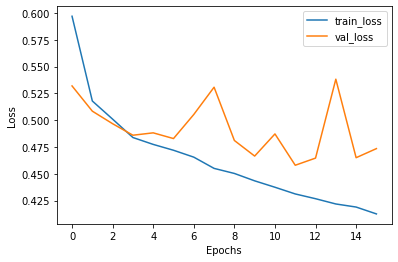

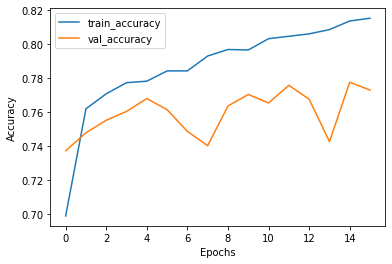

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.4677579998970032, 'binary_accuracy': 0.7689999938011169, 'false_negatives_1': 811.0, 'false_positives_1': 344.0}
----------------------------------------------------------------------------------------------------


In [ ]:
def train_full_model(full_train_dataset, val_dataset, test_dataset):
    model = create_model()
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # We will save the best model at every epoch and load the best one for evaluation on the test set
    history = model.fit(
        full_train_dataset.batch(256),
        epochs=25,
        validation_data=val_dataset,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=4, verbose=1),
            keras.callbacks.ModelCheckpoint(
                "FullModelCheckpoint.h5", verbose=1, save_best_only=True
            ),
        ],
    )

    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["binary_accuracy"],
        history.history["val_binary_accuracy"],
    )

    # Loading the best checkpoint
    model = keras.models.load_model("FullModelCheckpoint.h5")

    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)
    return model


# Sampling the full train dataset to train on
full_train_dataset = (
    train_dataset.concatenate(pool_positives)
    .concatenate(pool_negatives)
    .cache()
    .shuffle(20000)
)

# Training the full model
full_dataset_model = train_full_model(full_train_dataset, val_dataset, test_dataset)